<a href="https://colab.research.google.com/github/Prabodh-09/NeuralStyleTransfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Enter the path to your Content Image: /content/Scenery_.jpg
Enter the path to your Style Image: /content/van gogh.jpg


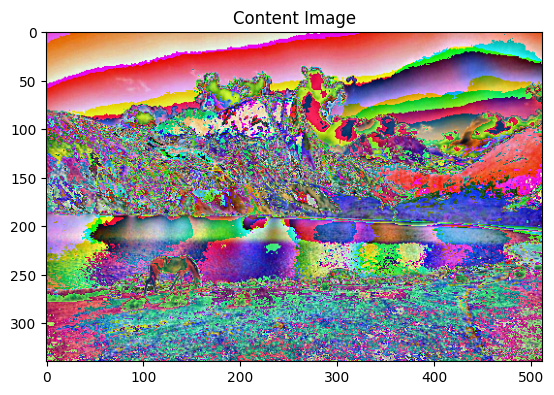

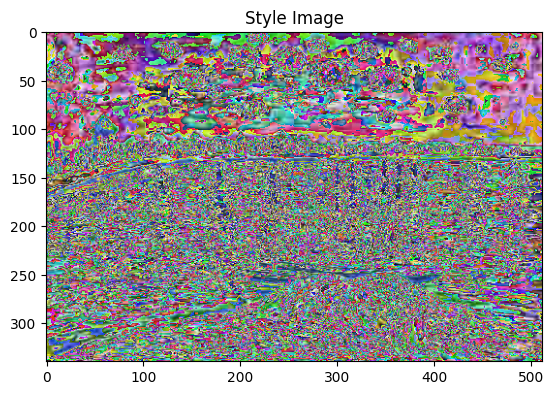

Iteration 0 - Total Loss: 59027456000.0


In [6]:
from IPython import get_ipython
from IPython.display import display
# %%
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Step 1: Image Loader
def load_image(image_path, max_size=512, shape=None):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error: {e}\nMake sure the image path is correct and the image exists.")
        return None

    # Determine the target size for resizing
    if shape:
        # If shape is provided, use it directly as the size tuple (height, width)
        size = shape
    else:
        # Otherwise, determine size based on max_size, keeping aspect ratio or squaring
        # The transforms.Resize expects (height, width) or a single int for square
        # Here we ensure it's a tuple (height, width) matching the original logic
        if max(image.size) > max_size:
             # Maintain aspect ratio while resizing the longest side to max_size
             ratio = max_size / max(image.size)
             size = (int(image.size[1] * ratio), int(image.size[0] * ratio)) # PIL expects (width, height)
        else:
             size = image.size # Use original size if smaller than max_size
             # Convert to tuple if not already, although image.size is usually a tuple


    # The transforms.Resize expects (height, width). PIL's image.size is (width, height).
    # Need to pass (height, width) to transforms.Resize
    if isinstance(size, int):
         resize_size = (size, size) # Square image if size is an integer
    elif isinstance(size, tuple) and len(size) == 2:
         # If size is a tuple (height, width), use it directly
         resize_size = size
    elif isinstance(size, tuple) and len(size) > 2:
         # If size was calculated based on PIL's image.size (width, height), swap it
         resize_size = (size[1], size[0])
    else:
         # Fallback or error handling for unexpected size format
         print(f"Warning: Unexpected size format: {size}. Using default max_size.")
         resize_size = (max_size, max_size)


    image_transform = transforms.Compose([
        transforms.Resize(resize_size), # Pass the correctly formatted size tuple
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = image_transform(image)[:3, :, :].unsqueeze(0)
    return image

# Step 2: Display Image
def imshow(tensor, title=None):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.show()

# Step 3: Save Image
def save_image(tensor, filename='stylized_output.jpg'):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    image.save(filename)
    print(f"Image saved as {filename}")

# Step 4: Load VGG19 Model
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

# Step 5: Content and Style Features Extraction
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content layer
        '28': 'conv5_1'
    }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Step 6: Gram Matrix for Style Representation
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# === User Inputs for Image Paths ===
content_path = input("Enter the path to your Content Image: ")
style_path = input("Enter the path to your Style Image: ")

# Step 7: Load Images
# Load content image first to get its shape for the style image
content = load_image(content_path).to(device)

# Check if content image loaded successfully before proceeding
if content is None:
    print("Exiting due to content image loading error.")
    import sys
    sys.exit()

# Now load the style image using the shape of the content image
style = load_image(style_path, shape=(content.shape[2], content.shape[3])).to(device)

# Check if style image loaded successfully
if style is None:
    print("Exiting due to style image loading error.")
    import sys
    sys.exit()


# Display Images
imshow(content, title='Content Image')
imshow(style, title='Style Image')

# Step 8: Optimization Setup
target = content.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)

# Enhanced Style Weights
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.5,
    'conv4_1': 0.25,
    'conv5_1': 0.1
}

content_weight = 1e4
style_weight = 1e6
tv_weight = 1e-5  # Total Variation weight

# Step 9: Total Variation Loss
def total_variation_loss(image):
    loss = torch.sum(torch.abs(image[:, :, :-1] - image[:, :, 1:])) + \
           torch.sum(torch.abs(image[:, :-1, :] - image[:, 1:, :]))
    return loss

# Step 10: Neural Style Transfer Loop
for i in range(500):
    target_features = get_features(target, vgg)
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    # Content Loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style Loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (target_feature.shape[2] * target_feature.shape[3])

    # Total Variation Loss
    tv_loss = tv_weight * total_variation_loss(target)

    # Total Loss
    total_loss = content_weight * content_loss + style_weight * style_loss + tv_loss

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration {i} - Total Loss: {total_loss.item()}")

# Step 11: Display and Save the Final Stylized Image
imshow(target, title='Stylized Image')
save_image(target, "stylized_output.jpg")